In [1]:
import pprint
import pandas as pd
from ORBIT import ProjectManager, SupplyChainManager, load_config
from ORBIT.supply_chain import DEFAULT_MULTIPLIERS, LABOR_SPLIT

pp = pprint.PrettyPrinter(indent=4)


In [2]:
# These are from the spreadsheet on teams
# They can be overridden in ORBIT/supply_chain.py or passed as a new dict
# into the manager class like SupplyChainManager(supply_chain, multipliers={different multipliers})
pp.pprint(DEFAULT_MULTIPLIERS)

{   'array_cable': {'domestic': 0.074, 'imported': 0.0},
    'blades': {'domestic': 0.026, 'imported': 0.31},
    'export_cable': {'domestic': 0.128, 'imported': 0.0},
    'monopile': {'domestic': 0.085, 'imported': 0.28, 'tariffs': 0.25},
    'nacelle': {'domestic': 0.025, 'imported': 0.07},
    'oss_substructure': {'domestic': 0.0, 'imported': 0.0},
    'oss_topside': {'domestic': 0.0, 'imported': 0.0},
    'tower': {'domestic': 0.04, 'imported': 0.12, 'tariffs': 0.25},
    'transition_piece': {'domestic': 0.169, 'imported': 0.18, 'tariffs': 0.25}}


In [3]:
# These are used for the tariff calculations: tariffs = (1 - labor_split) * total_cost * tariff_rate
# % of cost that is labor vs material
pp.pprint(LABOR_SPLIT)

{'monopile': 0.5, 'oss_topside': 0.5, 'tower': 0.5, 'transition_piece': 0.5}


In [100]:
# Load Sample Config
config = load_config("examples/configs/example_fixed_project.yaml")  ## TODO: Update to match COE Review
print(config)

{'site': {'depth': 22.5, 'distance': 124, 'distance_to_landfall': 35, 'mean_windspeed': 9}, 'plant': {'layout': 'grid', 'num_turbines': 50, 'row_spacing': 7, 'substation_distance': 1, 'turbine_spacing': 7}, 'landfall': {'interconnection_distance': 3, 'trench_length': 2}, 'turbine': 'SWT_6MW_154m_110m', 'array_cable_install_vessel': 'example_cable_lay_vessel', 'export_cable_install_vessel': 'example_cable_lay_vessel', 'export_cable_bury_vessel': 'example_cable_lay_vessel', 'oss_install_vessel': 'example_heavy_lift_vessel', 'spi_vessel': 'example_scour_protection_vessel', 'wtiv': 'example_wtiv', 'OffshoreSubstationInstallation': {'feeder': 'example_heavy_feeder', 'num_feeders': 1}, 'array_system_design': {'cables': ['XLPE_630mm_33kV', 'XLPE_400mm_33kV']}, 'export_system_design': {'cables': 'XLPE_500mm_132kV', 'percent_added_length': 0.0}, 'scour_protection_design': {'cost_per_tonne': 40, 'scour_protection_depth': 1}, 'design_phases': ['MonopileDesign', 'ScourProtectionDesign', 'ArraySyst

In [76]:
# Define supply chain scenario to use
# Options are imported, domestic or domestic, imported steel
supply_chain_scenarios = {
    2023: {
    "blades": "imported",
    "nacelle": "imported",
    "tower": "imported",
    "monopile": "imported",
    "transition_piece": "imported",
    "array_cable": "imported",
    "export_cable": "imported",
    "oss_topside": "imported"
},
    2025: {
    "blades": "domestic",
    "nacelle": "imported",
    "tower": "domestic, imported steel",
    "monopile": "domestic, imported steel",
    "transition_piece": "domestic, imported steel",
    "array_cable": "imported",
    "export_cable": "imported",
    "oss_topside": "domestic"       
    },
    2027: {
    "blades": "domestic",
    "nacelle": "domestic",
    "tower": "domestic, imported steel",
    "monopile": "domestic",
    "transition_piece": "domestic, imported steel",
    "array_cable": "domestic",
    "export_cable": "domestic",
    "oss_topside": "domestic"       
    },
    2030: {
    "blades": "domestic",
    "nacelle": "domestic",
    "tower": "domestic",
    "monopile": "domestic",
    "transition_piece": "domestic",
    "array_cable": "domestic",
    "export_cable": "domestic",
    "oss_topside": "domestic"      
    },
}

a = 'test'
years = []
scenarios = []
cost_breakdown = {
    'Turbine': [],
    'Substructure': [],
    'Electrical infrastructure': [],
}
total_capex = []
for k,v in supply_chain_scenarios.items():
    years.append(k)  # list of ints
    _v = SupplyChainManager(v)
    _sc_project = _v.run_project(config)
    cost_breakdown['Turbine'].append(_sc_project.capex_breakdown['Turbine']) # Nacelle, blades, tower
    cost_breakdown['Substructure'].append(_sc_project.capex_breakdown['Substructure'])  # Monopile, TP
    cost_breakdown['Electrical infrastructure'].append(_sc_project.capex_breakdown['Array System'] +
                                                       _sc_project.capex_breakdown['Export System'] +
                                                       _sc_project.capex_breakdown['Offshore Substation']
                                                      )  # Array cables, export cables, OSS
    total_capex.append(_sc_project.total_capex)
#     scenarios.append(_sc_project)  # list of ORBIT PM objs
# sc_manager = SupplyChainManager(supply_chain)


In [92]:
# Create some summary statistics
cost_breakdown_perc = {
    'Turbine': [],
    'Substructure': [],
    'Electrical infrastructure': [],
}
for k, v in cost_breakdown.items():
    perc = [100*(i/v[0] -1) for n,i in enumerate(v)]
    cost_breakdown_perc[k] = perc 
print(cost_breakdown_perc)

total_capex_perc = [100*(i/total_capex[0] - 1) for n,i in enumerate(total_capex)] 
print(total_capex_perc)

{'Turbine': [0.0, -4.747933769563273, -5.889103815931951, -5.889103815931951], 'Substructure': [0.0, 0.9993527510999689, -4.591385342776954, -9.120076223995188], 'Electrical infrastructure': [0.0, 0.0, 4.87467551933376, 4.87467551933376]}
[0.0, -1.7001046152922639, -2.622207230680773, -3.315720915047804]


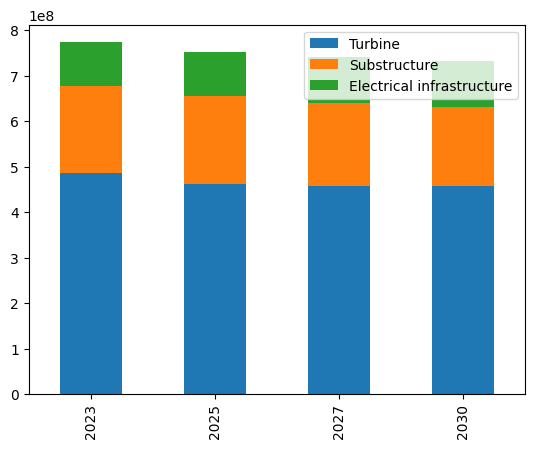

In [93]:
df = pd.DataFrame(cost_breakdown, index=years)
ax = df.plot.bar(stacked=True)

<AxesSubplot:>

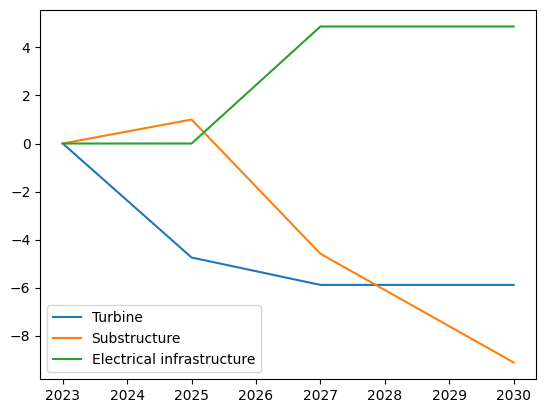

In [94]:
df_perc = pd.DataFrame(cost_breakdown_perc, index=years)
df_perc.plot()

### Old methods below

In [18]:
# Run a project through this method
# It will perform the supply chain adjustments and return a project instance with the adjusted values
sc_project = sc_manager.run_project(config)


<class 'ORBIT.manager.ProjectManager'>


In [7]:
# This is just for comparison
project = ProjectManager(config)
project.run()

In [8]:
# Comparing the values from SupplyChainManager vs. ProjectManager
df = pd.concat([
    pd.Series(project.capex_breakdown, name="ORBIT"),
    pd.Series(sc_project.capex_breakdown, name="SupplyChain")
], axis=1)

df["Ratio"] = df["SupplyChain"] / df["ORBIT"]

In [9]:
df

,ORBIT,SupplyChain,Ratio
Array System,2.441658e+07,2.622340e+07,1.074000
Export System,2.281350e+07,2.573363e+07,1.128000
Offshore Substation,4.973955e+07,4.973955e+07,1.000000
Scour Protection,5.896000e+06,5.896000e+06,1.000000
Substructure,1.544362e+08,1.926734e+08,1.247592
Array System Installation,1.305663e+07,1.305663e+07,1.000000
Export System Installation,6.203998e+07,6.203998e+07,1.000000
Offshore Substation Installation,3.409502e+06,3.409502e+06,1.000000
Scour Protection Installation,1.285632e+07,1.285632e+07,1.000000
Substructure Installation,2.249919e+07,2.249919e+07,1.000000
